In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special
from sklearn.linear_model import LassoCV, LogisticRegressionCV, LinearRegression, Lasso, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from econml.sklearn_extensions.model_selection import GridSearchCVList
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import joblib
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import math

In [ ]:
from sensitivity import dml_sensitivity_bounds, dml_tvalue
from sensitivity import sensitivity_bounds, tvalue, sensitivity_contours
from rfriesz import RFreg, RFrr, poly_feature_fns
from sievereisz import SieveRR, SparseSieveRR, Featurizer
from debiased import DebiasedMoment
from econml.dml import LinearDML

In [ ]:
# Generic machine learning regressor with cross validation
def first_stage_reg(numeric_columns=[], cv=None):
    return GridSearchCVList([
                             Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), numeric_columns)],
                                                                   remainder='passthrough')),
                                       ('lasso', Lasso())]),
                             Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), numeric_columns)],
                                                                   remainder='passthrough')),
                                       ('feat', Featurizer(degree=1, normalize=False)),
                                       ('lasso', Lasso())]),
                             RandomForestRegressor(n_estimators=100, random_state=123),
                             RFreg(reg_feature_fns=poly_feature_fns(10),
                                   min_var_leaf_on_val=True,
                                   min_impurity_decrease=1e-4, max_samples=.85, inference=False, subforest_size=1,
                                   random_state=123)
                            ],
                             param_grid_list=[
                                              {'lasso__alpha': [1e-6, 1e-5, 0.0001, .001, .01, .1, 1, 10]},
                                              {'lasso__alpha': [1e-6, 1e-5, 0.0001, .001, .01, .1, 1, 10]},
                                              {'max_depth': [3, 5],
                                               'min_samples_leaf': [10, 50]},
                                              {'reg_feature_fns': [poly_feature_fns(2)],
                                               'min_samples_leaf': [10],
                                               'min_var_fraction_leaf': [0.01, 0.1],
                                               'l2': [1e-3, 1e-2]}
                             ],
                             cv=cv,
                             scoring='neg_mean_squared_error',
                             n_jobs=-1)

In [ ]:
# Returns a function that when called with data (X, y), returns a generator that when called
# returns an un-fitted regression estimator; e.g. the one with the best hyperparameters.
def reg_fn_gen(numeric_columns, cv=None, verbose=0):
    def get_reg_fn(X, y):
        est = first_stage_reg(numeric_columns, cv=cv).fit(X, y)
        if verbose > 0:
            print('Chose: ', est.best_score_, est.best_estimator_)
            print('Scores: ', [(l.best_score_, l.best_estimator_) for l in est._gcv_list])
        return lambda: clone(est.best_estimator_)
    return get_reg_fn

In [ ]:
# The moment function, whose average we want to estimate: E[m(X; g)]
def moment_fn(x, test_fn):
    epsilon = 0.01
    t1 = np.hstack([x[:, [0]] + epsilon, x[:, 1:]])
    t0 = np.hstack([x[:, [0]] - epsilon, x[:, 1:]])
    return (test_fn(t1) - test_fn(t0)) / (2*epsilon)

In [ ]:
# The negative of the reisz score: L(g) := E[2 * m(X;g) - g(X)^2]
def neg_reisz_score(model, X):
    return np.mean(2 * moment_fn(X, model.predict) - model.predict(X)**2)

In [ ]:
# A generic machine learning riesz representer estimator with cross-validation
def first_stage_rr(numeric_columns, cv=None):
    return GridSearchCVList([
                            SieveRR(featurizer=Featurizer(degree=1), moment_fn=moment_fn),
                            SieveRR(featurizer=Featurizer(degree=2), moment_fn=moment_fn),
                            SieveRR(featurizer=Featurizer(degree=3), moment_fn=moment_fn),
                            SparseSieveRR(featurizer=Featurizer(degree=3), moment_fn=moment_fn, tol=1e-4),
                            SparseSieveRR(featurizer=Featurizer(degree=2), moment_fn=moment_fn, tol=1e-4),
                            SparseSieveRR(featurizer=Featurizer(degree=1), moment_fn=moment_fn, tol=1e-4),
                            RFrr(riesz_feature_fns=poly_feature_fns(10),
                                        moment_fn=moment_fn,
                                        min_var_leaf_on_val=True,
                                        min_impurity_decrease=0.001,
                                        max_samples=.65,
                                        inference=False,
                                        subforest_size=1,
                                        random_state=123)
                            ],
                            param_grid_list=[
                                   {'alpha': np.geomspace(1e-6, 1e3, 20)},
                                   {'alpha': np.geomspace(1e-6, 1e3, 20)},
                                   {'alpha': np.geomspace(1e-6, 1e3, 20)},
                                   {'alpha': np.geomspace(1e-6, 1e3, 20),
                                    'l1_ratio': [.5, 1.0]},
                                   {'alpha': np.geomspace(1e-6, 1e3, 20),
                                    'l1_ratio': [.5, 1.0]},
                                   {'alpha': np.geomspace(1e-6, 1e3, 20),
                                    'l1_ratio': [.5, 1.0]},
                                   {'riesz_feature_fns': [poly_feature_fns(2), poly_feature_fns(3)],
                                    'min_samples_leaf': [10, 50],
                                    'min_var_fraction_leaf': [0.01, 0.1],
                                    'l2': [1e-5, 1e-3],
                                    'max_depth': [5, None]}
                           ],
                           scoring=neg_reisz_score,
                           cv=cv, verbose=0, n_jobs=-1)

In [ ]:
# Returns a function that when called with data X, returns a generator that when called
# returns an un-fitted riesz estimator; e.g. the one with the best hyperparameters.
def rr_fn_gen(numeric_columns, cv=None, verbose=0):
    def get_rr_fn(X):
        est = first_stage_rr(numeric_columns, cv=cv).fit(X)
        if verbose > 0:
            print('Chose: ', est.best_score_, est.best_estimator_)
            print('Scores: ', [(l.best_score_, l.best_estimator_) for l in est._gcv_list])
        return lambda: clone(est.best_estimator_)
    return get_rr_fn

In [ ]:
# Data loading and manipulation

# for semi-synthetic data generation
def true_f(X):
    y = (-.7 - .4 * scipy.special.expit(3 * (1 - 2*(X[:, 1] - 10.5)))) * X[:, 0]
    y += scipy.special.expit(3 * (1 - 2 * (X[:, 1] > 11.5)))
    return y

# def true_f(X):
#     y = -.7 * X[:, 0]
#     y += scipy.special.expit(3 * (1 - 2 * (X[:, 1] > 11.5)))
#     return y

def get_data(q=None, synthetic=False, region=True, state=False, region_ids=None, random_seed=123):
    df = pd.read_csv('./BHP2017/data_BHP2_with_region.csv')
    # Throw away low prices and low income due to sample quality as in Chetverikov
    df = df[df["log_p"] > math.log(1.2)]
    df = df[df["log_y"] > math.log(15000)]
    if not ((q==4) | (q==5)): # all data in first three brackets
        df = df[df["log_y"] >= math.log(42500) - .5]
        df = df[df["log_y"] <= math.log(72500) + .5]
    if q == 1:
        df = df[df["log_y"] >= math.log(42500) - .5]
        df = df[df["log_y"] <= math.log(42500) + .5]
    if q == 2:
        df = df[df["log_y"] >= math.log(57500) - .5]
        df = df[df["log_y"] <= math.log(57500) + .5]
    if q == 3:
        df = df[df["log_y"] >= math.log(72500) - .5]
        df = df[df["log_y"] <= math.log(72500) + .5]
    if q == 4:
        df = df[df["log_y"] >= 11.6]
    if region_ids is not None: # Sub-select particular regions
        df = df[np.any([df['region'] == r for r in region_ids], axis=0)]
    Xdf = df.iloc[:, 1:] # Covariates
    X_nostatedum = Xdf.drop(["distance_oil1000", "share"], axis=1).values 
    if state: # whether to control for state id; almost no price variation left
        state_dum = pd.get_dummies(Xdf['state_fips'], prefix="state", drop_first=True)
        Xdf = pd.concat([Xdf, state_dum], axis = 1)
    if region: # whether to control for regrion id
        region_dum = pd.get_dummies(Xdf['region'], prefix="region", drop_first=True)
        Xdf = pd.concat([Xdf, region_dum], axis = 1)
    # Drop instrument and things we've one-hot encoded and weird share variable
    Xdf = Xdf.drop(["distance_oil1000", "state_fips", "share", 'region'], axis=1)
    X = Xdf.values # to numpy array
    y = df['log_q'].values # outcome to numpy array
    if synthetic: # impute synthetic outcome based on known relationship
        y = true_f(X) + np.random.normal(0, .2, size=X[:, 0].shape)
        print(np.mean(moment_fn(X, true_f)))
    
    # Create state-block-wise and stratified by region folds for cross validation and cross fitting
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_seed)
    splits = list(cv.split(df, y=df['region'], groups=df['state_fips']))
    return X, y, [0, 1, 6, 7, 8], splits

In [ ]:
# log-income distribution
X, y, num_cols, splits = get_data(5, region_ids=[1, 8])
plt.hist(X[:, 1])
plt.show()

In [ ]:
# global result dictionaries and global parameters
ests = {}
res = {}
res_d = {}
q_grid = np.arange(1, 6)
synthetic = False # use synthetic outcome
verbose = 0
region = True # control for region

In [ ]:
# General pipeline for all types of estimators to generate the estimation result we want
def generic_pipeline(estimator, q_grid, name, n_seeds=5):
    ests = {}
    res = {}
    for q in q_grid:
        print(f'q={q}')
        ests[f'q={q}'] = []
        estimate_list = []
        for random_seed in np.arange(123, 123 + n_seeds):
            X, y, num_cols, splits = get_data(q, region=region, synthetic=synthetic, random_seed=random_seed)
            estimates, model = estimator(X, y, num_cols, splits)
            print(estimates)
            estimate_list.append(estimates)
            ests[f'q={q}'].append(model)
        estimate_list = np.array(estimate_list)
        res[f'q={q}'] = {}
        res[f'q={q}'][f'{name}'] = {}
        res[f'q={q}'][f'{name}']['point'] = np.mean(estimate_list[:, 0])
        if estimate_list.shape[1] > 2:
            res[f'q={q}'][f'{name}']['stderr'] = np.sqrt(np.mean(estimate_list[:, 1]**2) 
                                                         + np.var(estimate_list[:, 0]))
        res[f'q={q}'] = pd.DataFrame(res[f'q={q}']).transpose()
    return pd.concat(res), ests

In [ ]:
# Transforming results to a nicely printable dataframe where each cell
# contains point (stderr) [ci_lower, ci_upper]
def transform_res_to_df(res, q_grid, alpha=None):
    res_f = res.reset_index()
    res_d = {}
    for q in q_grid:
        key = 'all <= 11.6' if q==0 else ('all' if q==5 else f'q={q}')
        res_d[key] = {}
        for method in np.unique(res_f['level_1'].values):
            p = res.loc[(f'q={q}', method), 'point']
            if alpha is not None:
                s = res.loc[(f'q={q}', method), 'stderr']
                error = scipy.stats.norm.ppf(1 - alpha) * s
                l, u = p - error, p + error
                res_d[key][method] = f"{p:.2f} ({s:.2f}) [{l:.2f}, {u:.2f}]"
            else:
                res_d[key][method] = f"{p:.2f}"
        
    return pd.DataFrame(res_d)

In [ ]:
if synthetic:
    def oracle_estimator(X, y, num_cols, splits):
        return (np.mean(moment_fn(X, true_f)),), None
    res['true'], _ = generic_pipeline(oracle_estimator, q_grid, 'true', n_seeds=1)
    res_d['true'] = transform_res_to_df(res['true'], q_grid)
    display(res_d['true'])

# Non-Linear RR Analysis

In [ ]:
# fully non-parametric average derivative estimation
def nonlinrr(X, y, num_cols, splits):
    get_reisz_fn = rr_fn_gen(num_cols, cv=splits, verbose=verbose)
    get_reg_fn = reg_fn_gen(num_cols, cv=splits, verbose=verbose)
    est = DebiasedMoment(moment_fn=moment_fn,
                         get_reisz_fn=get_reisz_fn,
                         get_reg_fn=get_reg_fn,
                         n_splits=splits)
    est.fit(X, y)
    return est.avg_moment(alpha=.1), est

In [ ]:
res['rr'], ests['rr'] = generic_pipeline(nonlinrr, q_grid, 'dr')

In [ ]:
res_d['rr'] = transform_res_to_df(res['rr'], q_grid, alpha=0.05)
res_d['rr']

### Sensitivity Analysis Example

In [ ]:
q = 5
est = ests['rr'][f'q={q}'][0] # look at one of the cv split seeds
X, y, num_cols, splits = get_data(q)

In [ ]:
p, s, l, u = est.avg_moment(alpha=.1)
print(f'{p:.2f}, ({s:.2f}) [{l:.2f}, {u:.2f}]')

In [ ]:
l, u = sensitivity_bounds([est], .03, .03, alpha=None)
print(f'[{l:.2f}, {u:.2f}]')

In [ ]:
l, u = sensitivity_bounds([est], .03, .03, alpha=.05)
print(f'[{l:.2f}, {u:.2f}]')

In [ ]:
print(f'{tvalue([est], value=0, leq=False, alpha=None):.3f}')

In [ ]:
print(f'{tvalue([est], value=0, leq=False, alpha=.05):.3f}')

In [ ]:
eta_asq, eta_ysq, lower, upper = sensitivity_contours([est], 0.15, 0.15, alpha=0.05)

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
contours = plt.contour(eta_asq, eta_ysq, lower, 6, linestyles='-', colors='blue')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('Lower limit')
plt.xlabel('Nonparametric partial R2 of confounder(s) with the treatment')
plt.ylabel('Nonparametric partial R2 of confounder(s) with the outcome')

plt.subplot(1, 2, 2)
contours = plt.contour(eta_asq, eta_ysq, upper, 6, linestyles='-', colors='blue')
plt.clabel(contours, inline=True, fontsize=8)
plt.title('Upper limit')
plt.xlabel('Nonparametric partial R2 of confounder(s) with the treatment')
plt.ylabel('Nonparametric partial R2 of confounder(s) with the outcome')

plt.show()

### Diagnostics examples

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], est.reg_pred_)
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], est.reisz_pred_)
plt.show()

# OLS analysis

In [ ]:
# fully linear OLS-based average derivative estimation
def ols_estimator(X, y, num_cols, splits):
    est = OLS(y, np.hstack([np.ones((X.shape[0], 1)), X])).fit(cov_type='HC3')
    return (est.params[1], est.bse[1], *est.conf_int(alpha=.1)[1]), est

In [ ]:
res['ols'], ests['ols'] = generic_pipeline(ols_estimator, q_grid, 'ols', n_seeds=1)

In [ ]:
res_d['ols'] = transform_res_to_df(res['ols'], q_grid, alpha=0.05)
res_d['ols']

# Lasso Analysis

In [ ]:
# fully linear Lasso-based average derivative estimation
def lasso_estimator(X, y, num_cols, splits):
    num_cols = [t - 1 for t in num_cols[1:]]

    est = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                    ('lasso', LassoCV(cv=splits))])
    est.fit(X, y)
    p = np.mean(est.predict(np.hstack([np.ones((X.shape[0], 1)), X[:, 1:]])) 
            - est.predict(np.hstack([np.zeros((X.shape[0], 1)), X[:, 1:]])))
    return (p,), est

In [ ]:
res['lasso'], ests['lasso'] = generic_pipeline(lasso_estimator, q_grid, 'lasso')

In [ ]:
res_d['lasso'] = transform_res_to_df(res['lasso'], q_grid)
res_d['lasso']

# DML Analysis

In [ ]:
# fully linear debiased Lasso-based average derivative estimation, with doubleML
def dml_lasso_estimator(X, y, num_cols, splits):
    num_cols = [t - 1 for t in num_cols[1:]]

    model_reg = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                          ('lasso', LassoCV(cv=splits))])
    model_y = clone(model_reg).fit(X[:, 1:], y)
    model_y = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                        ('lasso', Lasso(alpha=model_y.named_steps['lasso'].alpha_))])
    model_t = clone(model_reg).fit(X[:, 1:], X[:, 0])
    model_t = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                        ('lasso', Lasso(alpha=model_t.named_steps['lasso'].alpha_))])
    est = LinearDML(model_y=model_y,
                    model_t=model_t,
                    linear_first_stages=False,
                    cv=splits, random_state=123)
    est.fit(y, X[:, 0], W=X[:, 1:], cache_values=True)
    p = est.intercept__inference().point_estimate
    s = est.intercept__inference().stderr
    l, u = est.intercept__inference().conf_int(alpha=.1)
    return (p, s, l, u), est

In [ ]:
res['dml_lasso'], ests['dml_lasso'] = generic_pipeline(dml_lasso_estimator, q_grid, 'dml_lasso')

In [ ]:
res_d['dml_lasso'] = transform_res_to_df(res['dml_lasso'], q_grid, alpha=.05)
res_d['dml_lasso']

# DML with Non-Linear Residualizers

In [ ]:
# partially linear average derivative estimation, with doubleML
def dml_estimator(X, y, num_cols, splits):
    num_cols = [t - 1 for t in num_cols[1:]]

    model_y = reg_fn_gen(num_cols, cv=splits, verbose=verbose)(X[:, 1:], y)
    model_t = reg_fn_gen(num_cols, cv=splits, verbose=verbose)(X[:, 1:], X[:, 0])
    est = LinearDML(model_y=model_y(),
                    model_t=model_t(),
                    linear_first_stages=False,
                    cv=splits, random_state=123)
    est.fit(y, X[:, 0], W=X[:, 1:], cache_values=True)
    p = est.intercept__inference().point_estimate
    s = est.intercept__inference().stderr
    l, u = est.intercept__inference().conf_int(alpha=.1)
    return (p, s, l, u), est

In [ ]:
res['dml'], ests['dml'] = generic_pipeline(dml_estimator, q_grid, 'dml')

In [ ]:
res_d['dml'] = transform_res_to_df(res['dml'], q_grid, alpha=.05)
res_d['dml']

# Put all results together

In [ ]:
res_d_all = pd.concat(res_d)

In [ ]:
heading_properties = [('font-size', '11px')]

cell_properties = [('font-size', '11px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

res_d_all.style.set_table_styles(dfstyle)

# Paper tables

In [ ]:
table = {}
table['point'] = '{:.3f} ({:.3f})'.format(res['rr'].loc[(f'q={5}', 'dr'), 'point'],
                                          res['rr'].loc[(f'q={5}', 'dr'), 'stderr'])

est_list = ests['rr'][f'q={5}']
table['Bounds'] = '[{:.3f}, {:.3f}]'.format(*sensitivity_bounds(est_list, .03, .03, alpha=None))
table['CIBounds'] = '[{:.3f}, {:.3f}]'.format(*sensitivity_bounds(est_list, .03, .03, alpha=.05))
table['RV(v=-1.5)'] = '{:.3f}'.format(tvalue(est_list, value=-1.5, leq=True, alpha=None))
table['RV(v=-1.5,a=.05)'] = '{:.3f}'.format(tvalue(est_list, value=-1.5, leq=True, alpha=.05))
table['RV(v=0)'] = '{:.3f}'.format(tvalue(est_list, value=0, leq=False, alpha=None))
table['RV(v=0,a=.05)'] = '{:.3f}'.format(tvalue(est_list, value=0, leq=False, alpha=.05))

In [ ]:
table2 = {}
table2['point'] = '{:.3f} ({:.3f})'.format(res['dml_lasso'].loc[(f'q={5}', 'dml_lasso'), 'point'],
                                          res['dml_lasso'].loc[(f'q={5}', 'dml_lasso'), 'stderr'])

est_list = ests['dml_lasso'][f'q={5}']
table2['Bounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .03, .03, alpha=None))
table2['CIBounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .03, .03, alpha=.05))
table2['RV(v=-1.5)'] = '{:.3f}'.format(dml_tvalue(est_list, value=-1.5, leq=True, alpha=None))
table2['RV(v=-1.5,a=.05)'] = '{:.3f}'.format(dml_tvalue(est_list, value=-1.5, leq=True, alpha=.05))
table2['RV(v=0)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=False, alpha=None))
table2['RV(v=0,a=.05)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=False, alpha=.05))

In [ ]:
table2 = {}
table2['point'] = '{:.3f} ({:.3f})'.format(res['dml'].loc[(f'q={5}', 'dml'), 'point'],
                                          res['dml'].loc[(f'q={5}', 'dml'), 'stderr'])

est_list = ests['dml'][f'q={5}']
table2['Bounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .03, .03, alpha=None))
table2['CIBounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .03, .03, alpha=.05))
table2['RV(v=-1.5)'] = '{:.3f}'.format(dml_tvalue(est_list, value=-1.5, leq=True, alpha=None))
table2['RV(v=-1.5,a=.05)'] = '{:.3f}'.format(dml_tvalue(est_list, value=-1.5, leq=True, alpha=.05))
table2['RV(v=0)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=False, alpha=None))
table2['RV(v=0,a=.05)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=False, alpha=.05))

In [ ]:
tabledf = pd.DataFrame({'Non-parametric': table, 'Partially linear': table2}).T[['point', 'Bounds', 'CIBounds',
                                                                                 'RV(v=-1.5)', 'RV(v=-1.5,a=.05)',
                                                                                 'RV(v=0)', 'RV(v=0,a=.05)']]
tabledf

In [68]:
print(tabledf.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &           point &            Bounds &         CIBounds & RV(v=-1.5) & RV(v=-1.5,a=.05) & RV(v=0) & RV(v=0,a=.05) \\
\midrule
Non-parametric   &  -0.761 (0.360) &  [-1.232, -0.291] &  [-1.827, 0.314] &      0.047 &            0.010 &   0.049 &         0.011 \\
Partially linear &  -0.701 (0.257) &  [-1.147, -0.254] &  [-1.576, 0.172] &      0.054 &            0.026 &   0.047 &         0.019 \\
\bottomrule
\end{tabular}



# Paper income quantile plots

### Based on separate nuisance fitting per sub-group

In [ ]:
qgr = np.arange(1, 5)

point = [res['rr'].loc[(f'q={q}', 'dr'), 'point'] for q in qgr]
lower = [res['rr'].loc[(f'q={q}', 'dr'), 'point'] - 1.645*res['rr'].loc[(f'q={q}', 'dr'), 'stderr']
         for q in qgr]
upper = [res['rr'].loc[(f'q={q}', 'dr'), 'point'] + 1.645*res['rr'].loc[(f'q={q}', 'dr'), 'stderr']
         for q in qgr]
sens_band = [sensitivity_bounds(ests['rr'][f'q={q}'], .03, .03, alpha=None) for q in qgr]
sens_band_unc = [sensitivity_bounds(ests['rr'][f'q={q}'], .03, .03, alpha=.05) for q in qgr]

if synthetic:
    true_moment = [res['true'].loc[(f'q={q}', 'true'), 'point'] for q in qgr]

plt.figure(figsize=(5, 5))
plt.plot(qgr, point)
plt.fill_between(qgr, lower, upper, alpha=.4, label='5%-95% CI')
plt.fill_between(qgr, *list(zip(*sens_band)), alpha=.6, label='Bounds')
plt.fill_between(qgr, *list(zip(*sens_band_unc)), alpha=.2, label='5%-95% Bounds')
if synthetic:
    plt.plot(qgr, true_moment, label='true')
plt.xticks(qgr)
plt.title('Non-parametric')
plt.legend()
plt.grid()
plt.savefig('nonparam_quantile_avgder.pdf', dpi=600)

point = [res['dml'].loc[(f'q={q}', 'dml'), 'point'] for q in qgr]
lower = [res['dml'].loc[(f'q={q}', 'dml'), 'point'] - 1.645*res['dml'].loc[(f'q={q}', 'dml'), 'stderr']
         for q in qgr]
upper = [res['dml'].loc[(f'q={q}', 'dml'), 'point'] + 1.645*res['dml'].loc[(f'q={q}', 'dml'), 'stderr']
         for q in qgr]
sens_band = [dml_sensitivity_bounds(ests['dml'][f'q={q}'], .03, .03, alpha=None) for q in qgr]
sens_band_unc = [dml_sensitivity_bounds(ests['dml'][f'q={q}'], .03, .03, alpha=.05) for q in qgr]

plt.figure(figsize=(5, 5))
plt.plot(qgr, point)
plt.fill_between(qgr, lower, upper, alpha=.4, label='5%-95% CI')
plt.fill_between(qgr, *list(zip(*sens_band)), alpha=.6, label='Bounds')
plt.fill_between(qgr, *list(zip(*sens_band_unc)), alpha=.2, label='5%-95% Bounds')
if synthetic:
    plt.plot(qgr, true_moment, label='true')
plt.xticks(qgr)
plt.title('Partially linear')
plt.legend()
plt.grid()
plt.savefig('plinear_quantile_avgder.pdf', dpi=600)

### Based on fitted nuisances on all data as is done in 401k example

In [77]:
X, _, _, _ = get_data(5, synthetic=synthetic, random_seed=123)
inds = np.arange(X.shape[0])
splits = [inds[(X[:, 1] >= math.log(42500) - .5) & (X[:, 1] <= math.log(42500) + .5)],
          inds[(X[:, 1] >= math.log(57500) - .5) & (X[:, 1] <= math.log(57500) + .5)],
          inds[(X[:, 1] >= math.log(72500) - .5) & (X[:, 1] <= math.log(72500) + .5)],
          inds[(X[:, 1] >= 11.6)]]
point, stderr, bounds, cibounds = np.zeros(4), np.zeros(4), np.zeros((4, 2)), np.zeros((4, 2))
qgr = np.arange(4)
for q in qgr:
    points = np.array([np.mean(est.moment_[splits[q]]) for est in ests['rr']['q=5']])
    stderrs = np.array([np.sqrt(np.var(est.moment_[splits[q]])/len(splits[q])) for est in ests['rr']['q=5']])
    point[q] = np.mean(points)
    stderr[q] = np.sqrt(np.mean(stderrs**2) + np.var(points))
    bounds[q, :] = sensitivity_bounds(ests['rr']['q=5'], .04, .03, inds=splits[q])
    cibounds[q, :] = sensitivity_bounds(ests['rr']['q=5'], .04, .03, alpha=0.05, inds=splits[q])

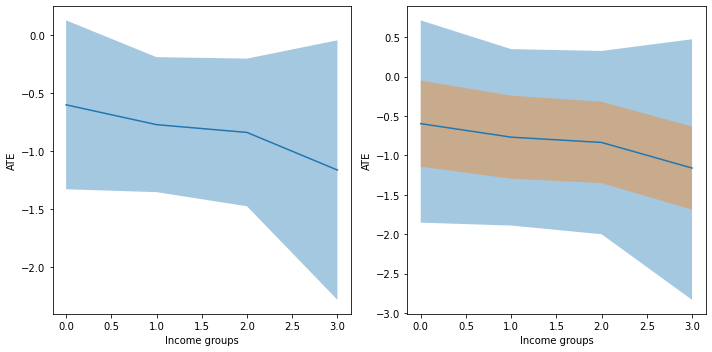

In [79]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.fill_between(qgr, point - 1.645*stderr, point + 1.645*stderr, alpha=.4)
plt.plot(qgr, point)
plt.xlabel("Income groups")
plt.ylabel("ATE")

plt.subplot(1, 2, 2)
plt.fill_between(qgr, cibounds[:, 0], cibounds[:, 1], alpha=.4)
plt.fill_between(qgr, bounds[:, 0], bounds[:, 1], alpha=.4)
plt.plot(qgr, point)
plt.xlabel("Income groups")
plt.ylabel("ATE")
plt.tight_layout()
plt.show()

# Paper contour plots

In [ ]:
eta_asq, eta_ysq, lower, upper = sensitivity_contours(ests['rr']['q=5'], 0.1, 0.1, alpha=0.05)

In [ ]:
plt.figure(figsize=(5, 5))
# plt.contourf(X, Y, Zlower)
# plt.colorbar() # Add a colorbar to a plot
contours = plt.contour(eta_asq, eta_ysq, lower,
                       10, linestyles='-', colors='blue')
plt.clabel(contours, inline=True, fontsize=8)
# contours = plt.contour(eta_asq, eta_ysq, lower, levels=[-1.5], linestyles='--', colors='r')
# plt.clabel(contours, inline=True, fontsize=8)
# plt.title('Lower limit')
# plt.xlabel('Proportion of variance of long RR not explained by short RR')
plt.xlabel('Information increase on location of treatment by confounder,\n'
            'relative to information in long specification.')
plt.ylabel('Nonparametric partial R2 of confounder(s) with the outcome')
plt.savefig('lower_avg_der_nonparam.pdf', dpi=600)

plt.figure(figsize=(5, 5))
# plt.contourf(X, Y, Zupper)
# plt.colorbar() # Add a colorbar to a plot
contours = plt.contour(eta_asq, eta_ysq, upper,
                       [-.2] + list(np.arange(.2, 1.8, .2)), linestyles='-', colors='blue')
plt.clabel(contours, inline=True, fontsize=8)
contours = plt.contour(eta_asq, eta_ysq, upper, levels=[0], linestyles='--', colors='r')
plt.clabel(contours, inline=True, fontsize=8)
# plt.title('Upper limit')
# plt.xlabel('Proportion of variance of long RR not explained by short RR')
plt.xlabel('Information increase on location of treatment by confounder,\n'
            'relative to information in long specification')
plt.ylabel('Nonparametric partial R2 of confounder(s) with the outcome')
# plt.tight_layout()
plt.savefig('upper_avg_der_nonparam.pdf', dpi=600)

# Distribution of Regions Across Income Brackets

In [ ]:
for q in range(6):
    df = pd.read_csv('./BHP2017/data_BHP2_with_region.csv')
    df = df[df["log_p"] > math.log(1.2)]
    df = df[df["log_y"] > math.log(15000)]
    if not ((q==4) | (q==5)):
        df = df[df["log_y"] >= math.log(42500) - .5]
        df = df[df["log_y"] <= math.log(72500) + .5]
    if q == 1:
        df = df[df["log_y"] >= math.log(42500) - .5]
        df = df[df["log_y"] <= math.log(42500) + .5]
    if q == 2:
        df = df[df["log_y"] >= math.log(57500) - .5]
        df = df[df["log_y"] <= math.log(57500) + .5]
    if q == 3:
        df = df[df["log_y"] >= math.log(72500) - .5]
        df = df[df["log_y"] <= math.log(72500) + .5]
    if q == 4:
        df = df[df["log_y"] >= 11.6]
    plt.hist(df['region'])
    plt.show()

# Data summaries

In [ ]:
df = pd.read_csv('./BHP2017/data_BHP2_with_region.csv')
df.shape

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
df = df[df["log_p"] > math.log(1.2)]
df = df[df["log_y"] > math.log(15000)]

In [ ]:
q = 5
if not ((q==4) | (q==5)):
    df = df[df["log_y"] >= math.log(42500) - .5]
    df = df[df["log_y"] <= math.log(72500) + .5]
if q == 1:
    df = df[df["log_y"] >= math.log(42500) - .5]
    df = df[df["log_y"] <= math.log(42500) + .5]
if q == 2:
    df = df[df["log_y"] >= math.log(57500) - .5]
    df = df[df["log_y"] <= math.log(57500) + .5]
if q == 3:
    df = df[df["log_y"] >= math.log(72500) - .5]
    df = df[df["log_y"] <= math.log(72500) + .5]
if q == 4:
    df = df[df["log_y"] >= 11.6]

In [ ]:
region_ids = None
synthetic = False
state = False
region = True
if region_ids is not None:
    df = df[np.any([df['region'] == r for r in region_ids], axis=0)]
Xdf = df.iloc[:, 1:]
X_nostatedum = Xdf.drop(["distance_oil1000", "share"], axis=1).values
if state:
    state_dum = pd.get_dummies(Xdf['state_fips'], prefix="state", drop_first=True)
    Xdf = pd.concat([Xdf, state_dum], axis = 1)
if region:
    region_dum = pd.get_dummies(Xdf['region'], prefix="region", drop_first=True)
    Xdf = pd.concat([Xdf, region_dum], axis = 1)
Xdf = Xdf.drop(["distance_oil1000", "state_fips", "share", 'region'], axis=1)
X = Xdf.values
y = df['log_q'].values
if synthetic:
    y = X[:, 0] + np.random.normal(0, .1, size=X[:, 0].shape)

In [ ]:
X.shape

In [ ]:
Xdf.columns

In [ ]:
len(np.unique(Xdf['log_y']))

In [ ]:
Xdf[:50]

In [ ]:
plt.hist(df['region'])
plt.show()